<a href="https://colab.research.google.com/github/sierraechobravoindia/RL_Schulung/blob/main/DemoCode_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 10/10 [00:00<00:00, 319.52it/s]


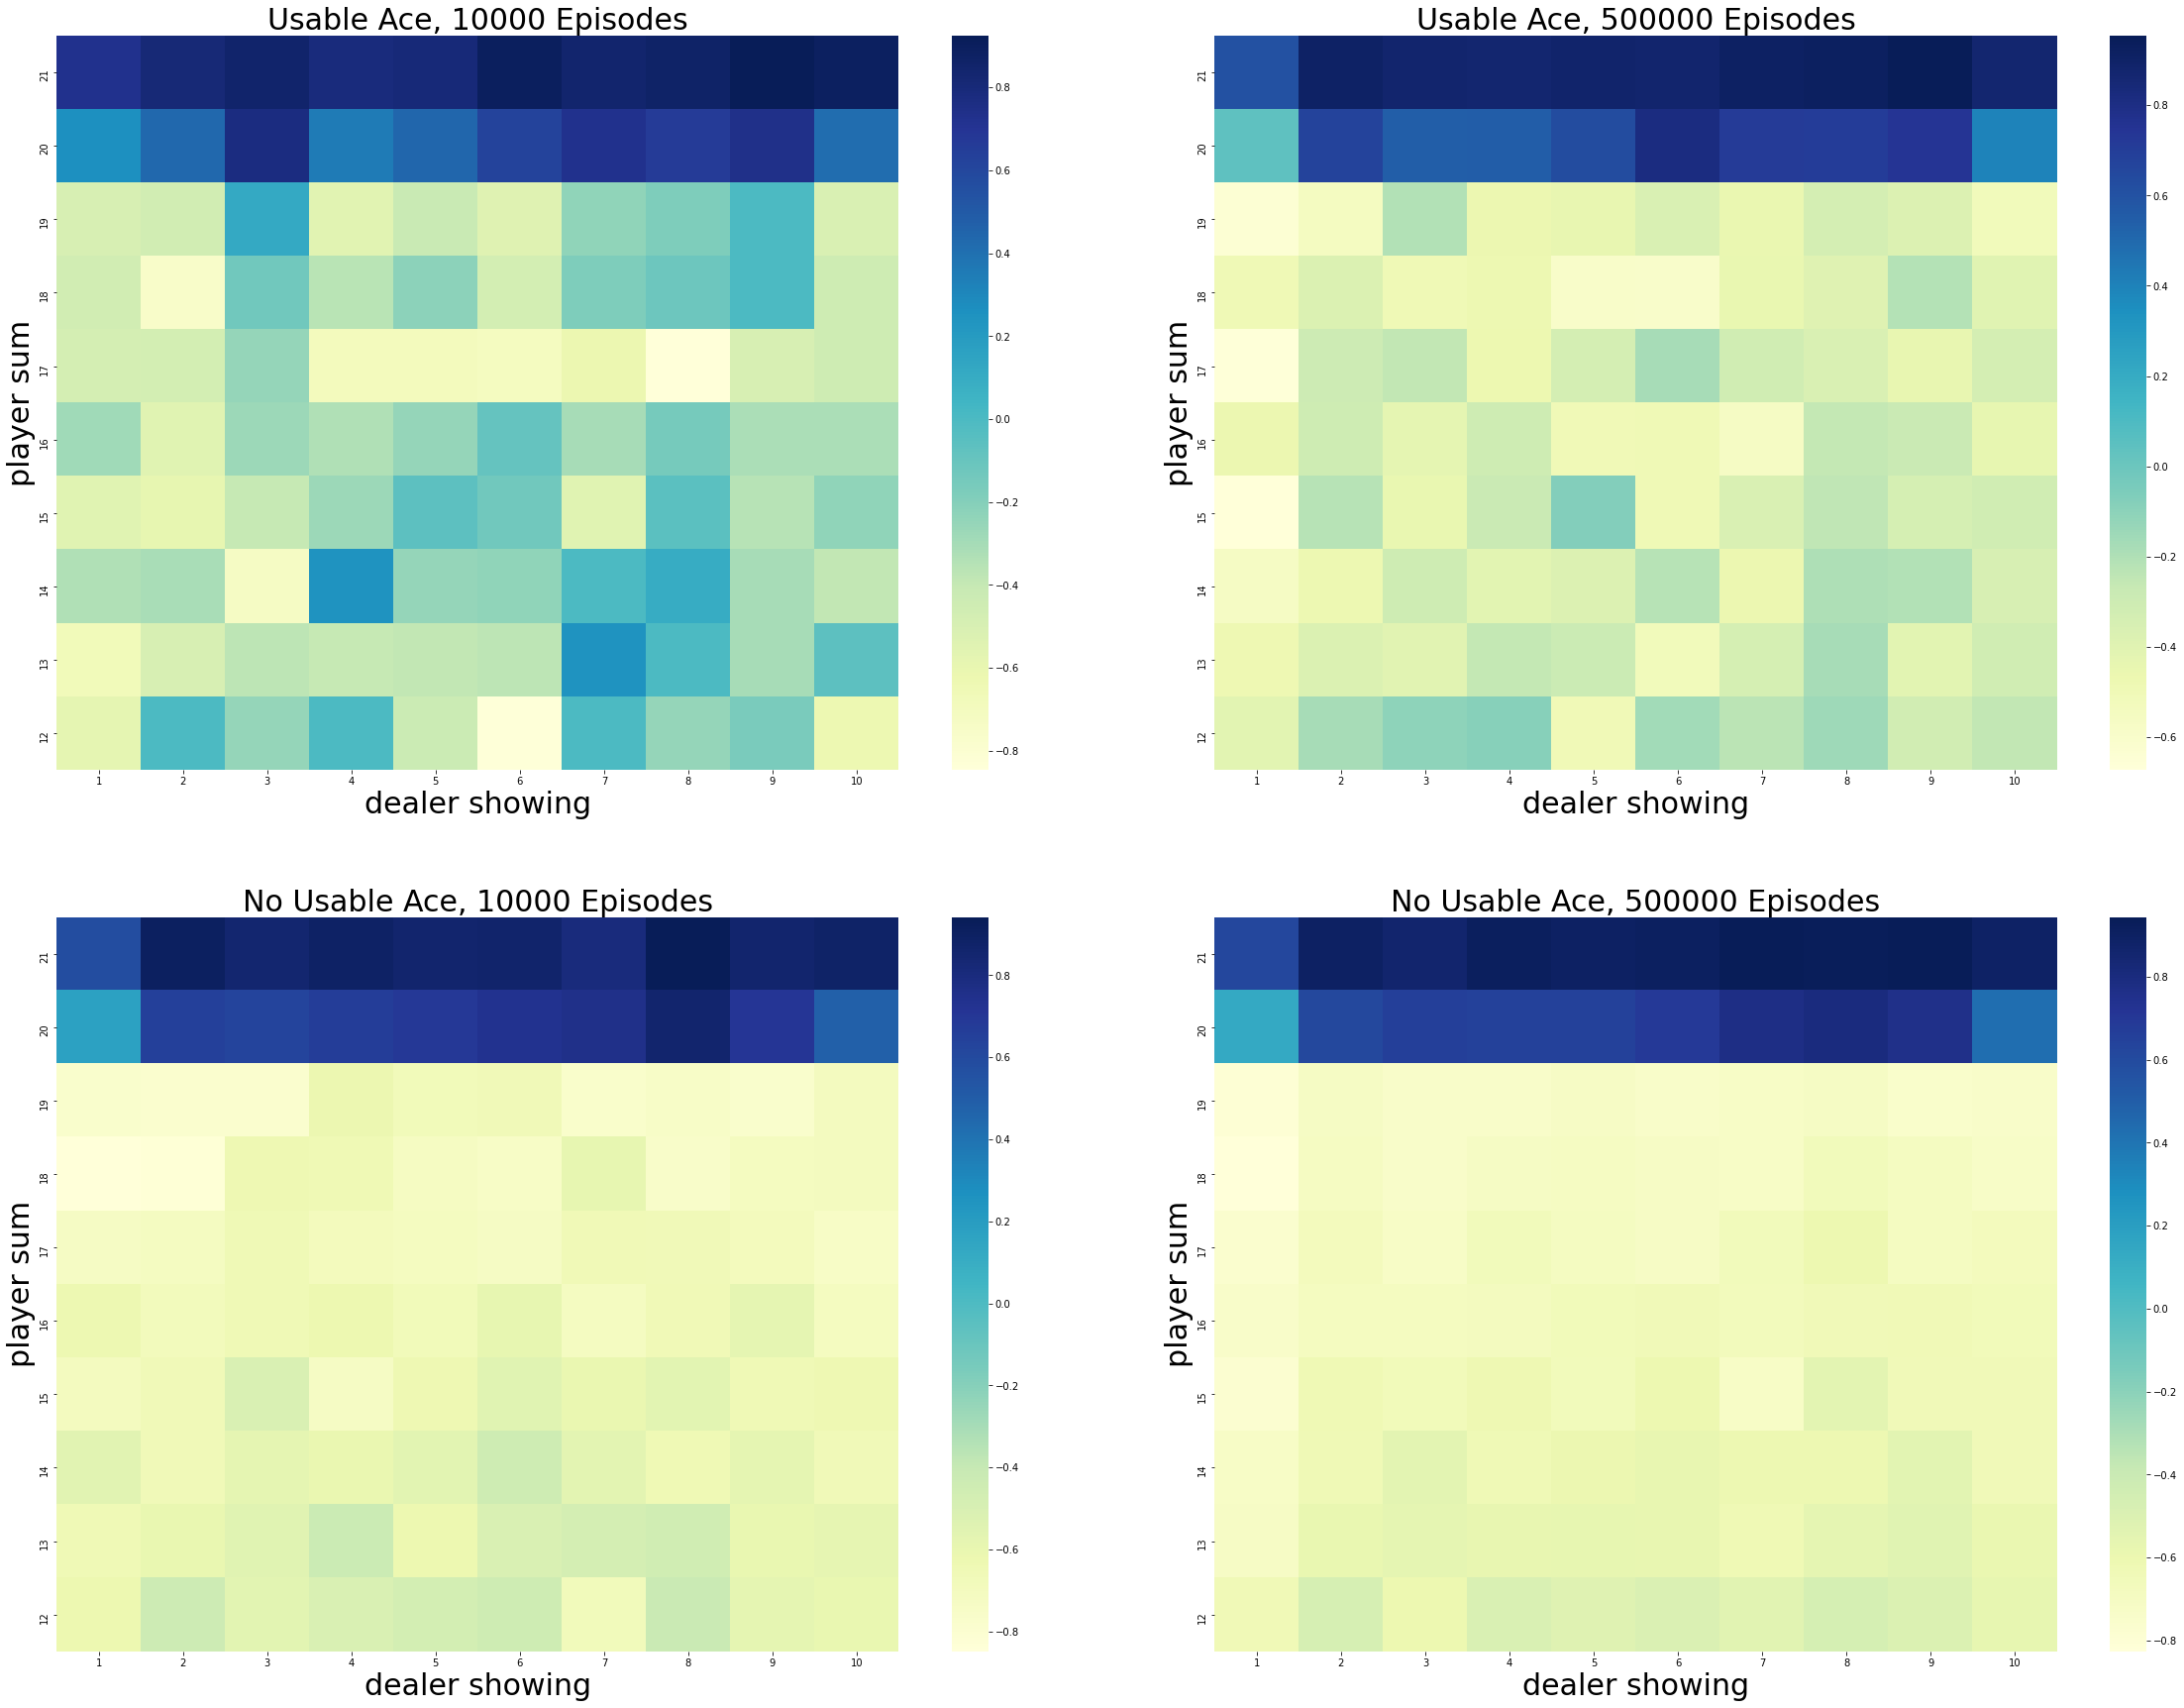

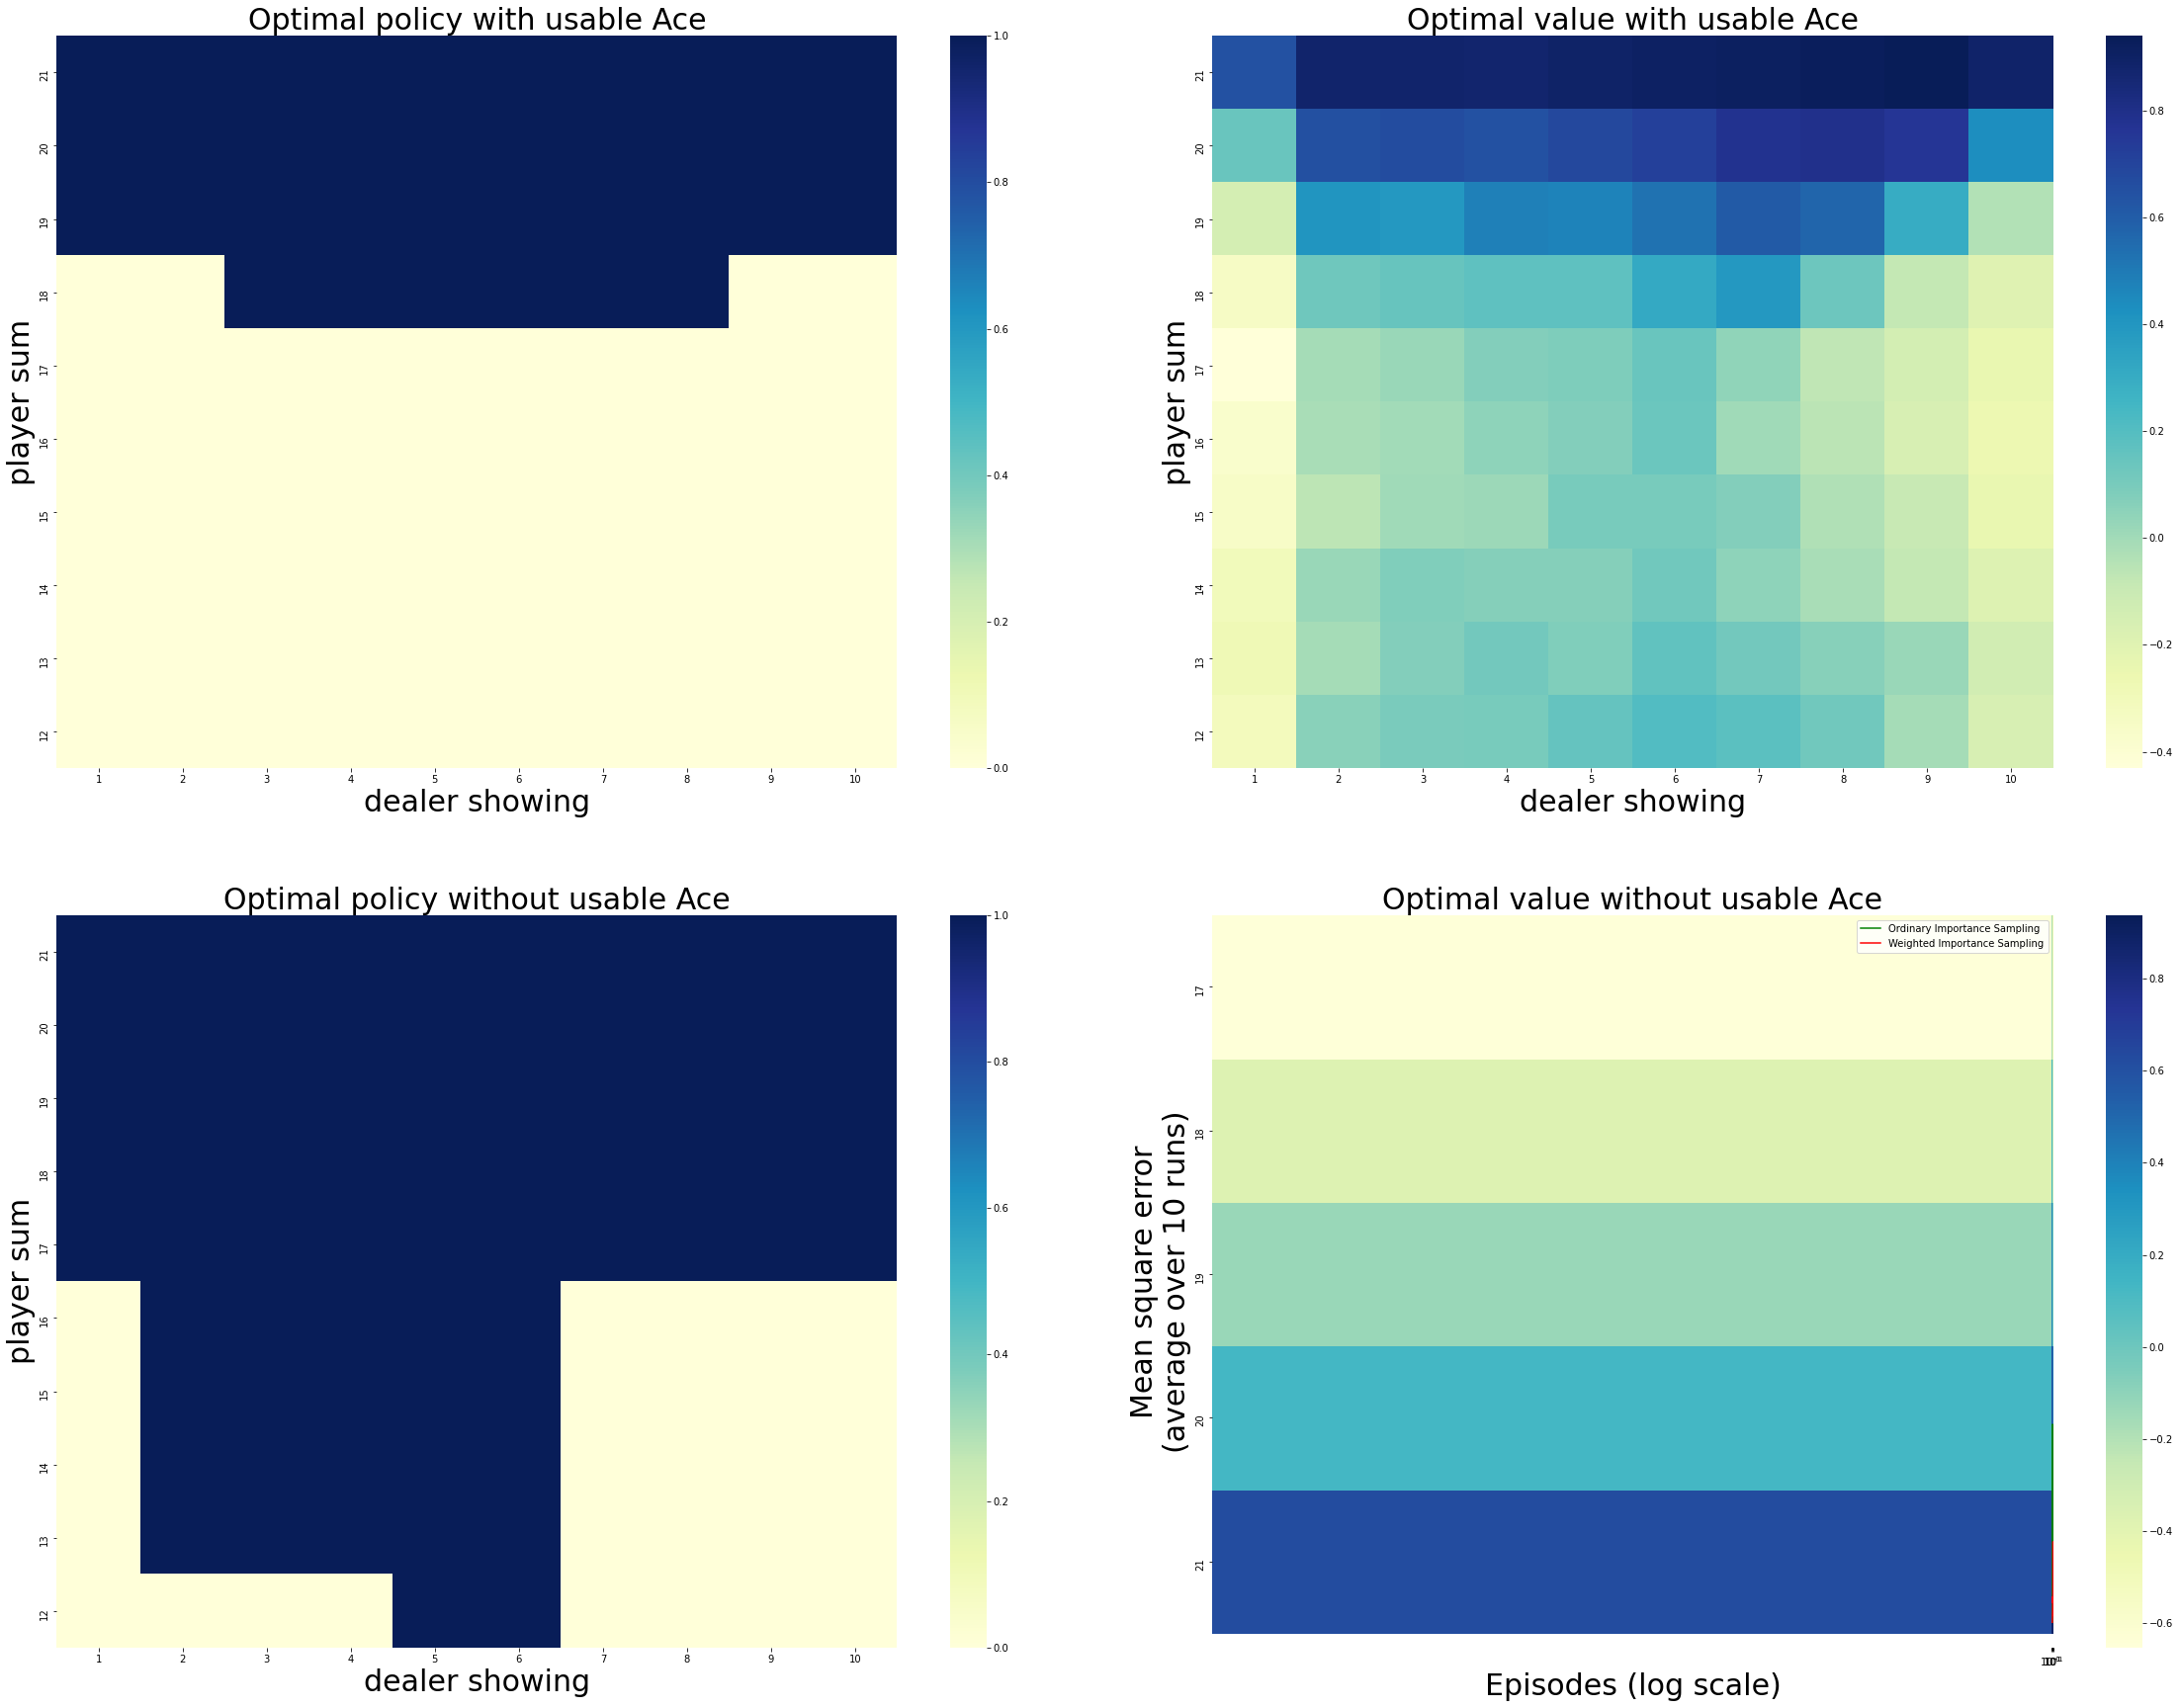

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1  #  "strike" in the book
ACTIONS = [ACTION_HIT, ACTION_STAND]

# policy for player
POLICY_PLAYER = np.zeros(22, dtype=np.int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

# function form of target policy of player
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# function form of behavior policy of player
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

# policy for dealer
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

# get a new card
def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# get the value of a card (11 for ace).
def card_value(card_id):
    return 11 if card_id == 1 else card_id

# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initial_action: the initial action
def play(policy_player, initial_state=None, initial_action=None):
    # player status

    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    if initial_state is None:
        # generate a random initial state

        while player_sum < 12:
            # if sum of player is less than 12, always hit
            card = get_card()
            player_sum += card_value(card)

            # If the player's sum is larger than 21, he may hold one or two aces.
            if player_sum > 21:
                assert player_sum == 22
                # last card must be ace
                player_sum -= 10
            else:
                usable_ace_player |= (1 == card)

        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealer_card1 = get_card()
        dealer_card2 = get_card()

    else:
        # use specified initial state
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()

    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21

    # game starts!

    # player's turn
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND:
            break
        # if hit, get new card
        card = get_card()
        # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two.
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # dealer's turn
    while True:
        # get action based on current sum
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory

# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):
    states_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_usable_ace_count = np.ones((10, 10))
    states_no_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_no_usable_ace_count = np.ones((10, 10))
    for i in tqdm(range(0, episodes)):
        _, reward, player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12
            dealer_card -= 1
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count

# Monte Carlo with Exploring Starts
def monte_carlo_es(episodes):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        current_policy = behavior_policy if episode else target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count

# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(0, episodes):
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    rhos = np.asarray(rhos)
    returns = np.asarray(returns)
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling

def figure_5_1():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(50000)

    states = [states_usable_ace_1,
              states_usable_ace_2,
              states_no_usable_ace_1,
              states_no_usable_ace_2]

    titles = ['Usable Ace, 10000 Episodes',
              'Usable Ace, 500000 Episodes',
              'No Usable Ace, 10000 Episodes',
              'No Usable Ace, 500000 Episodes']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for state, title, axis in zip(states, titles, axes):
        fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    #plt.savefig('../images/figure_5_1.png')
    plt.show()
    #plt.close()

def figure_5_2():
    state_action_values = monte_carlo_es(500000)

    state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

    # get the optimal policy
    action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

    images = [action_usable_ace,
              state_value_usable_ace,
              action_no_usable_ace,
              state_value_no_usable_ace]

    titles = ['Optimal policy with usable Ace',
              'Optimal value with usable Ace',
              'Optimal policy without usable Ace',
              'Optimal value without usable Ace']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    #plt.savefig('../images/figure_5_2.png')
    plt.show()
    #plt.close()

def figure_5_3():
    true_value = -0.27726
    episodes = 100
    runs = 10
    error_ordinary = np.zeros(episodes)
    error_weighted = np.zeros(episodes)
    for i in tqdm(range(0, runs)):
        ordinary_sampling_, weighted_sampling_ = monte_carlo_off_policy(episodes)
        # get the squared error
        error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
        error_weighted += np.power(weighted_sampling_ - true_value, 2)
    error_ordinary /= runs
    error_weighted /= runs

    plt.plot(np.arange(1, episodes + 1), error_ordinary, color='green', label='Ordinary Importance Sampling')
    plt.plot(np.arange(1, episodes + 1), error_weighted, color='red', label='Weighted Importance Sampling')
    plt.ylim(-0.1, 5)
    plt.xlabel('Episodes (log scale)')
    plt.ylabel(f'Mean square error\n(average over {runs} runs)')
    plt.xscale('log')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_5_3.png')
    #plt.close()


if __name__ == '__main__':
    figure_5_1()
    figure_5_2()
    figure_5_3()

In [3]:
import gym

env = gym.make("CartPole-v1")
env.reset()
for _ in range(1000):
  env.render()
  action = env.action_space.sample()
  env.step(action)

env.close()

NoSuchDisplayException: ignored

In [4]:
import gym
env = gym.make("CartPole-v1")
observation = env.reset()
for _ in range(1000):
  env.render()
  action = env.action_space.sample() # your agent here (this takes random actions)
  observation, reward, done, info = env.step(action)

  if done:
    observation = env.reset()
env.close()

NameError: ignored

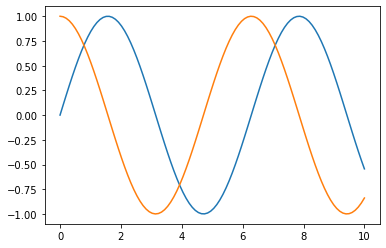

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
 
x = np.linspace(0, 10, 100)
 
plt.plot(x, np.sin(x))
plt.plot(x, np.cos(x))
 
plt.show()

In [8]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet


from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v0')
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(40):
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.
     |████████████████████████████████| 71kB 2.2MB/s 


NameError: ignored

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)


In [3]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
env = wrap_env(gym.make("MountainCar-v0"))
#env = wrap_env(gym.make("Atlantis-v0"))

observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()